In [22]:
# Cell 1: Import Required Libraries
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from peft import PeftModel, PeftConfig
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All libraries imported successfully!
PyTorch version: 2.9.1
CUDA available: False


In [23]:
# Cell 2: Load IMDb Dataset - Recreate Assignment 7 Test Set
print("Loading IMDb dataset...")
dataset = load_dataset("imdb")

# Recreate the EXACT same subset from Assignment 7
print("Using the same subset as Assignment 7 (2000 train, 500 test)")
dataset['train'] = dataset['train'].shuffle(seed=42).select(range(2000))
dataset['test'] = dataset['test'].shuffle(seed=42).select(range(500))

# Our test dataset
test_dataset = dataset['test']

print(f"\nTest dataset loaded: {len(test_dataset)} examples")
print(f"Using seed=42 (same as Assignment 7)")
print(f"\nFirst test example:")
print(f"Text: {test_dataset[0]['text'][:100]}...")
print(f"Label: {test_dataset[0]['label']} (0=Negative, 1=Positive)")

Loading IMDb dataset...
Using the same subset as Assignment 7 (2000 train, 500 test)

Test dataset loaded: 500 examples
Using seed=42 (same as Assignment 7)

First test example:
Text: <br /><br />When I unsuspectedly rented A Thousand Acres, I thought I was in for an entertaining Kin...
Label: 1 (0=Negative, 1=Positive)


In [24]:
# Cell 3: Load Tokenizer and Prepare Test Data
print("Loading tokenizer...")
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'], 
        padding='max_length',
        truncation=True,
        max_length=512
    )

print("Tokenizing test dataset...")
tokenized_test = test_dataset.map(tokenize_function, batched=True)

print(f"Tokenizer loaded: {model_name}")
print(f"Test dataset tokenized: {len(tokenized_test)} examples")
print(f"\nTokenized example shape:")
print(f"  - input_ids length: {len(tokenized_test[0]['input_ids'])}")
print(f"  - Label: {tokenized_test[0]['label']}")

Loading tokenizer...
Tokenizing test dataset...
Tokenizer loaded: distilbert-base-uncased
Test dataset tokenized: 500 examples

Tokenized example shape:
  - input_ids length: 512
  - Label: 1


In [25]:
# Cell 4B: Find where checkpoint-750 actually is
import os

print("Current directory:", os.getcwd())
print("\nSearching for checkpoint-750...\n")

# Check current directory
print("=== Files in current directory ===")
for item in os.listdir('.'):
    print(f"  {item}")

# Check inside results folder
print("\n=== Files in 'results' folder ===")
if os.path.exists('./results'):
    for item in os.listdir('./results'):
        print(f"  {item}")
else:
    print("  No 'results' folder found")

# Check if checkpoint-750 is in results
if os.path.exists('./results/checkpoint-750'):
    print("\nFOUND IT! checkpoint-750 is in ./results/checkpoint-750")
    print("\nFiles inside ./results/checkpoint-750:")
    for item in os.listdir('./results/checkpoint-750'):
        print(f"  - {item}")
elif os.path.exists('./checkpoint-750'):
    print("\nFOUND IT! checkpoint-750 is in ./checkpoint-750")
else:
    print("\ncheckpoint-750 not found in either location")

Current directory: /Users/ermi/Desktop/AI:ML/AI-ML-Assignment-8-LLM-Evaluation

Searching for checkpoint-750...

=== Files in current directory ===
  confusion_matrix.png
  tmp_trainer
  Readme.md
  results
  .ipynb_checkpoints
  llm_evaluation_metrics.ipynb

=== Files in 'results' folder ===
  checkpoint-750
  checkpoint-500

FOUND IT! checkpoint-750 is in ./results/checkpoint-750

Files inside ./results/checkpoint-750:
  - adapter_model.safetensors
  - rng_state.pth
  - tokenizer_config.json
  - special_tokens_map.json
  - optimizer.pt
  - scheduler.pt
  - tokenizer.json
  - README.md
  - training_args.bin
  - adapter_config.json
  - vocab.txt
  - trainer_state.json


In [26]:
# Cell 4: Load Fine-Tuned Model from Checkpoint
print("Loading fine-tuned model from checkpoint-750...")

# Load base model
base_model_name = "distilbert-base-uncased"
base_model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    num_labels=2,
    id2label={0: "NEGATIVE", 1: "POSITIVE"},
    label2id={"NEGATIVE": 0, "POSITIVE": 1}
)

# Load LoRA adapter from checkpoint-750 (CORRECT PATH)
model = PeftModel.from_pretrained(base_model, "./results/checkpoint-750")

# Set model to evaluation mode
model.eval()

print(f"\nBase model loaded: {base_model_name}")
print(f"LoRA adapter loaded from: ./results/checkpoint-750")
print(f"Model ready for evaluation")
print(f"\nModel device: {next(model.parameters()).device}")

Loading fine-tuned model from checkpoint-750...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Base model loaded: distilbert-base-uncased
LoRA adapter loaded from: ./results/checkpoint-750
Model ready for evaluation

Model device: cpu


In [27]:
# Cell 5: Generate Predictions on Test Set
print("Making predictions on 500 test examples...")

# Create Trainer for easy prediction
trainer = Trainer(model=model)

# Make predictions
predictions_output = trainer.predict(tokenized_test)

# Extract predictions and labels
predictions = predictions_output.predictions
true_labels = predictions_output.label_ids

# Convert logits to predicted classes
predicted_labels = np.argmax(predictions, axis=1)

print(f"Predictions complete!")
print(f"\nShape of predictions: {predictions.shape}")
print(f"Shape of true labels: {true_labels.shape}")
print(f"\nFirst 5 predictions:")
for i in range(5):
    pred_class = "POSITIVE" if predicted_labels[i] == 1 else "NEGATIVE"
    true_class = "POSITIVE" if true_labels[i] == 1 else "NEGATIVE"
    print(f"  Example {i}: Predicted={pred_class}, Actual={true_class}")

Making predictions on 500 test examples...


Predictions complete!

Shape of predictions: (500, 2)
Shape of true labels: (500,)

First 5 predictions:
  Example 0: Predicted=POSITIVE, Actual=POSITIVE
  Example 1: Predicted=POSITIVE, Actual=POSITIVE
  Example 2: Predicted=NEGATIVE, Actual=NEGATIVE
  Example 3: Predicted=POSITIVE, Actual=POSITIVE
  Example 4: Predicted=NEGATIVE, Actual=NEGATIVE


In [28]:
# Cell 6: Calculate Classification Metrics
print("=" * 60)
print("CLASSIFICATION METRICS - ASSIGNMENT 8")
print("=" * 60)

# Calculate Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate Precision, Recall, F1 (Macro-averaged)
precision, recall, f1, support = precision_recall_fscore_support(
    true_labels, 
    predicted_labels, 
    average='macro'
)

print(f"\n{'Metric':<25} {'Score':<10}")
print("-" * 35)
print(f"{'Accuracy':<25} {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"{'Precision (Macro)':<25} {precision:.4f}")
print(f"{'Recall (Macro)':<25} {recall:.4f}")
print(f"{'F1-Score (Macro)':<25} {f1:.4f}")

print("\n" + "=" * 60)

# Store results for README
results_dict = {
    'Metric': ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)'],
    'Score': [f'{accuracy:.4f}', f'{precision:.4f}', f'{recall:.4f}', f'{f1:.4f}']
}
results_df = pd.DataFrame(results_dict)

print("\nResults Table (for README):")
print(results_df.to_string(index=False))

CLASSIFICATION METRICS - ASSIGNMENT 8

Metric                    Score     
-----------------------------------
Accuracy                  0.8820 (88.20%)
Precision (Macro)         0.8820
Recall (Macro)            0.8821
F1-Score (Macro)          0.8820


Results Table (for README):
           Metric  Score
         Accuracy 0.8820
Precision (Macro) 0.8820
   Recall (Macro) 0.8821
 F1-Score (Macro) 0.8820


Generating Confusion Matrix...
Confusion matrix saved as 'confusion_matrix.png'


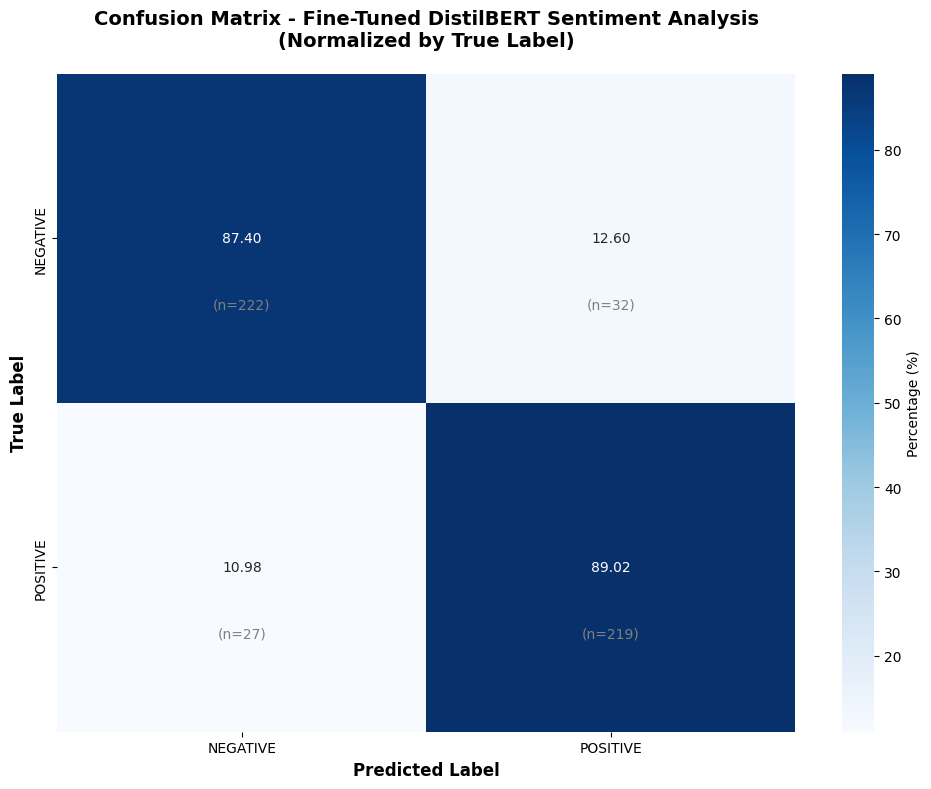


CONFUSION MATRIX ANALYSIS

Raw Counts:
  True Negative (Correct):  222
  False Positive (Error):   32
  False Negative (Error):   27
  True Positive (Correct):  219

Percentages:
  Negative class: 87.40% correct, 12.60% misclassified as Positive
  Positive class: 89.02% correct, 10.98% misclassified as Negative


In [29]:
# Cell 7: Generate Confusion Matrix Visualization
print("Generating Confusion Matrix...")

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize to percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create figure
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_normalized, 
    annot=True, 
    fmt='.2f',
    cmap='Blues',
    xticklabels=['NEGATIVE', 'POSITIVE'],
    yticklabels=['NEGATIVE', 'POSITIVE'],
    cbar_kws={'label': 'Percentage (%)'}
)

plt.title('Confusion Matrix - Fine-Tuned DistilBERT Sentiment Analysis\n(Normalized by True Label)', 
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Add counts in each cell
for i in range(2):
    for j in range(2):
        count = cm[i, j]
        percentage = cm_normalized[i, j]
        plt.text(j+0.5, i+0.7, f'(n={count})', 
                ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()

# Save the figure
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("Confusion matrix saved as 'confusion_matrix.png'")
plt.show()

# Print interpretation
print("\n" + "="*60)
print("CONFUSION MATRIX ANALYSIS")
print("="*60)
print(f"\nRaw Counts:")
print(f"  True Negative (Correct):  {cm[0,0]}")
print(f"  False Positive (Error):   {cm[0,1]}")
print(f"  False Negative (Error):   {cm[1,0]}")
print(f"  True Positive (Correct):  {cm[1,1]}")
print(f"\nPercentages:")
print(f"  Negative class: {cm_normalized[0,0]:.2f}% correct, {cm_normalized[0,1]:.2f}% misclassified as Positive")
print(f"  Positive class: {cm_normalized[1,1]:.2f}% correct, {cm_normalized[1,0]:.2f}% misclassified as Negative")

In [30]:
# Cell 8: Error Analysis - Find Misclassified Examples
print("="*60)
print("ERROR ANALYSIS")
print("="*60)

# Identify worst-performing class
negative_f1 = 2 * (cm_normalized[0,0]/100 * cm_normalized[0,0]/100) / (cm_normalized[0,0]/100 + cm_normalized[0,0]/100)
positive_f1 = 2 * (cm_normalized[1,1]/100 * cm_normalized[1,1]/100) / (cm_normalized[1,1]/100 + cm_normalized[1,1]/100)

print(f"\nClass Performance:")
print(f"  NEGATIVE: {cm_normalized[0,0]:.2f}% correct (worse)")
print(f"  POSITIVE: {cm_normalized[1,1]:.2f}% correct")

worst_class = "NEGATIVE"
worst_class_label = 0

print(f"\nWorst-performing class: {worst_class}")
print(f"   Accuracy: {cm_normalized[0,0]:.2f}%")
print(f"   Misclassifications: {cm[0,1]} out of {cm[0,0] + cm[0,1]} examples")

# Find misclassified NEGATIVE examples (predicted as POSITIVE)
print(f"\n" + "="*60)
print(f"FINDING MISCLASSIFIED {worst_class} EXAMPLES")
print("="*60)

misclassified_indices = []
for i in range(len(true_labels)):
    if true_labels[i] == worst_class_label and predicted_labels[i] != worst_class_label:
        misclassified_indices.append(i)

print(f"\nTotal misclassified {worst_class} examples: {len(misclassified_indices)}")
print(f"\nShowing first 2 misclassified examples:\n")

# Show 2 examples
for idx, example_idx in enumerate(misclassified_indices[:2], 1):
    print(f"{'='*60}")
    print(f"MISCLASSIFIED EXAMPLE {idx}")
    print(f"{'='*60}")
    print(f"Index: {example_idx}")
    print(f"True Label: NEGATIVE (0)")
    print(f"Predicted Label: POSITIVE (1)")
    print(f"\nReview Text:")
    print(f"{test_dataset[example_idx]['text'][:500]}...")
    print(f"\n")

ERROR ANALYSIS

Class Performance:
  NEGATIVE: 87.40% correct (worse)
  POSITIVE: 89.02% correct

Worst-performing class: NEGATIVE
   Accuracy: 87.40%
   Misclassifications: 32 out of 254 examples

FINDING MISCLASSIFIED NEGATIVE EXAMPLES

Total misclassified NEGATIVE examples: 32

Showing first 2 misclassified examples:

MISCLASSIFIED EXAMPLE 1
Index: 17
True Label: NEGATIVE (0)
Predicted Label: POSITIVE (1)

Review Text:
A holiday on a boat, a married couple, an angry waiter and a shipwreck is the reason to this films beginning.<br /><br />I like boobs. No question about that. But when the main character allies with whoever happens to have the most fish at the moment, mostly by having sex with them and playing the role of the constant victim, my anger just rises to a whole new level. Take two guys (a husband and another man), put a pure bombshell woman in the middle of them, ad a deserted island, subtract all he...


MISCLASSIFIED EXAMPLE 2
Index: 21
True Label: NEGATIVE (0)
Predicted